# Common Emitter Biasing

> Ref:
> * Introduction to Radio Frequency Design, by Wes Hayward w7zoi [Page 10]
> * Experimental Methods in RF Design, by Wes Hayward w7zoi, Rick Campbell kk7b, Bob Larkin w7pua



In [1]:
import sys

# from eseries import E12, E24, E48, E96, erange, find_nearest

sys.path.append("../../lib")
from biasing import interactive_draw_bjt_bias

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

display(interactive_draw_bjt_bias)

interactive(children=(Select(description='Transistor Type', options=('npn', 'pnp'), rows=2, style=DescriptionS…

---
### Notes
Assuming $R_5$ is initially zero.  The node $V^{'}_c$ is described using:

$$
\frac{V_{cc} - V^{'}_c}{R_4} = \beta I_b + \frac{V^{'}_c - V_b}{R_1}
$$

at the base:

$$
\frac{V^{'}_c - V_b}{R_1} = I_b + \frac{V_b}{R_2}
$$

the base current being related to base voltage using:

$$
\frac{V_b - \Delta V}{R_3} = I_b (\beta + 1)
$$

Solving for $V_b$:

$$
V_b = \frac{V_{cc} R_2 R_3 + \Delta V R_2 [R_4 + \frac{R_1}{(\beta + 1)}]}{R_3 R_4 + R_2 R_4 + R_2 R_3 + R_1 R_3 + \frac{R_1 R_2}{(\beta + 1)}}
$$

for $V^{'}_c$:

$$
V^{'}_c = \frac{R_1 V_{cc} + R_4 V_b + \beta R_1 R_4 \frac{\Delta V - V_b}{R_3 (\beta + 1)} }{R_1 + R_4}
$$

for $I_b$:

$$
I_b = \frac{V_b - \Delta V}{R_3 (\beta + 1)}
$$

then $I_e$ is:

$$
I_e = I_b (\beta + 1)
$$

Once the above has been resolved, $R_5$ can be added.  Final collector voltage is:

$$
V_c = V^{'}_c - \beta I_b R_5
$$

assert $V_b < V_c$

The Transistor's collector power dissipation can be given as:

$$
P_{cd} = (V_c - V_e) I_b \beta
$$

### Reference example from EMRFD Ladpac-2008 biasnpn08.exe (run under win32 on linux):

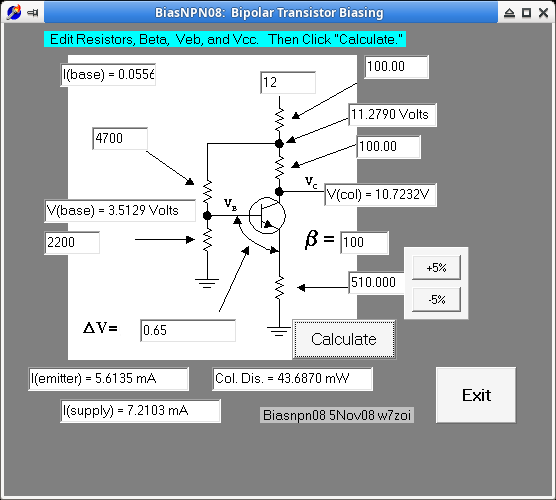

### Screenshot: Of notebook using same component values as above:

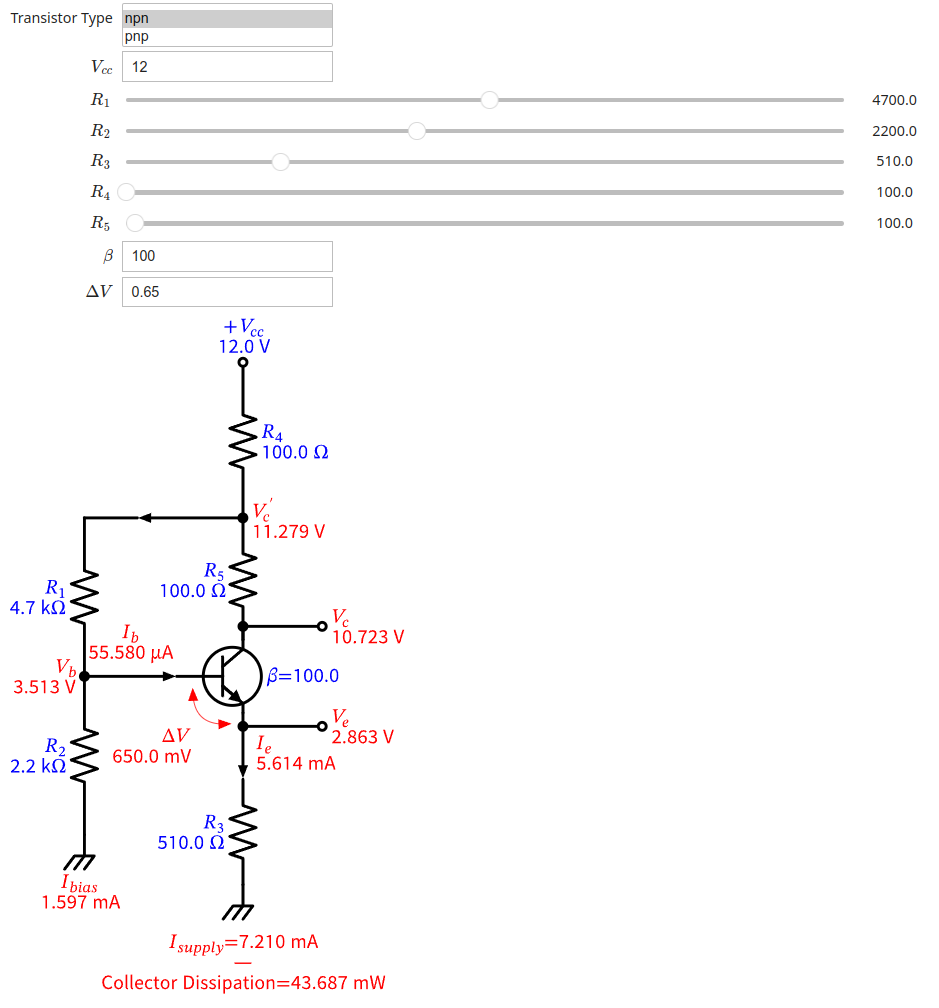